Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bioinfokit.analys import stat
from statsmodels.graphics.mosaicplot import mosaic

pd.set_option('display.max_columns', 100)

%matplotlib inline

### Read data

In [2]:
df = pd.read_csv('../data/processed/wound_outcomes_v1.csv')

### Value counts for ИСХОД

In [3]:
df['ИСХОД'].value_counts()

0    1882
1      65
2      15
Name: ИСХОД, dtype: int64

In [4]:
df = pd.get_dummies(df, columns=['тип', 'ВГА', 'ИСХОД'], drop_first=False)

# 'ИСХОД' = ИСХОД_1 OR ИСХОД_2
df['ИСХОД'] = df['ИСХОД_1'] + df ['ИСХОД_2']

In [5]:
df.head()

,Off pump,КШ,Соч,тип_E,тип_П,тип_Т,ВГА_0,ВГА_1,ВГА_2,ИСХОД_0,ИСХОД_1,ИСХОД_2,ИСХОД
0,0,1,0,1,0,0,0,1,0,1,0,0,0
1,1,1,0,1,0,0,0,1,0,1,0,0,0
2,0,1,1,1,0,0,0,1,0,1,0,0,0
3,0,1,1,1,0,0,0,1,0,1,0,0,0
4,0,1,0,1,0,0,0,1,0,1,0,0,0


In [6]:
df.sum()

Off pump     775
КШ          1831
Соч          364
тип_E       1613
тип_П        124
тип_Т        225
ВГА_0        150
ВГА_1       1463
ВГА_2        349
ИСХОД_0     1882
ИСХОД_1       65
ИСХОД_2       15
ИСХОД         80
dtype: int64

### Rename columns

In [7]:
df.rename(columns={'ВГА_1':'МКШ', 'тип_Т':'Т-БМКШ', 'тип_П':'П-БМКШ'}, inplace = True)
df.head()

,Off pump,КШ,Соч,тип_E,П-БМКШ,Т-БМКШ,ВГА_0,МКШ,ВГА_2,ИСХОД_0,ИСХОД_1,ИСХОД_2,ИСХОД
0,0,1,0,1,0,0,0,1,0,1,0,0,0
1,1,1,0,1,0,0,0,1,0,1,0,0,0
2,0,1,1,1,0,0,0,1,0,1,0,0,0
3,0,1,1,1,0,0,0,1,0,1,0,0,0
4,0,1,0,1,0,0,0,1,0,1,0,0,0


### Investigating the relationship between surgery types and wound outcomes

#### Groups of interest: 'ВГА_0', 'МКШ', 'П-БМКШ', 'Т-БМКШ'

`df_test` DataFrame which contains relevant columns

In [8]:
df_test = df[['ВГА_0', 'МКШ', 'П-БМКШ', 'Т-БМКШ', 'ИСХОД']].copy()
df_test.head()

,ВГА_0,МКШ,П-БМКШ,Т-БМКШ,ИСХОД
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0


Check that groups do not ovelap with each other

In [9]:
col_sum = df_test['ВГА_0'] + df_test['МКШ'] + df_test['П-БМКШ'] + df_test['Т-БМКШ']
col_sum.value_counts()

1    1962
dtype: int64

In [10]:
df_test.head()

,ВГА_0,МКШ,П-БМКШ,Т-БМКШ,ИСХОД
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0


Contingency table

In [11]:
df_ct = df_test.groupby('ИСХОД').sum().transpose().astype('int')
df_ct

ИСХОД,0,1
ВГА_0,147,3
МКШ,1411,52
П-БМКШ,113,11
Т-БМКШ,211,14


Mosaic plot

In [12]:
df_mp = (pd.melt(df_test, id_vars=['ИСХОД'], value_vars=['ВГА_0', 'МКШ', 'П-БМКШ', 'Т-БМКШ'], var_name='group')
            .query('value== 1')
            .sort_values(['ИСХОД', 'group'])
            .drop('value',1))

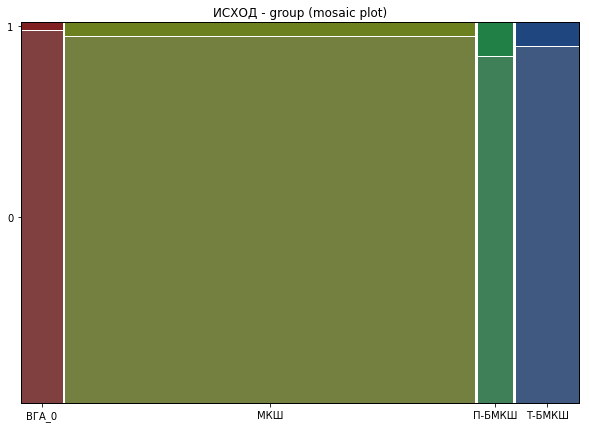

In [13]:
fig, ax = plt.subplots(1, 1,  figsize=(10, 7))

_ = mosaic(df_mp, ['group','ИСХОД'], ax=ax, labelizer=lambda _: "", title='ИСХОД - group (mosaic plot)')

Run test and print test results

In [14]:
res = stat()
res.chisq(df_ct)
print (res.summary)


Chi-squared test for independence

Test              Df    Chi-square     P-value
--------------  ----  ------------  ----------
Pearson            3       12.6098  0.00556107
Log-likelihood     3       10.9005  0.0122765



In [15]:
# Print expected values
print (res.expected_df)


Expected frequency counts

           0         1
--  --------  --------
 0   143.884   6.11621
 1  1403.35   59.6534
 2   118.944   5.05607
 3   215.826   9.17431



#### Groups of interest: 'Off pump', 'On pump'

`df_test` DataFrame which contains relevant columns

In [16]:
df_test = df[['Off pump', 'ИСХОД']].copy()
df_test['On pump'] = 1 - df_test[['Off pump']]
df_test.head()

,Off pump,ИСХОД,On pump
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


Contingency table

In [17]:
df_ct = df_test.groupby('ИСХОД').sum().transpose().astype('int')
df_ct

ИСХОД,0,1
Off pump,738,37
On pump,1144,43


Mosaic plot

In [18]:
df_mp = (pd.melt(df_test, id_vars=['ИСХОД'], value_vars=['On pump', 'Off pump'], var_name='group')
            .query('value== 1')
            .sort_values(['ИСХОД', 'group'])
            .drop('value',1))

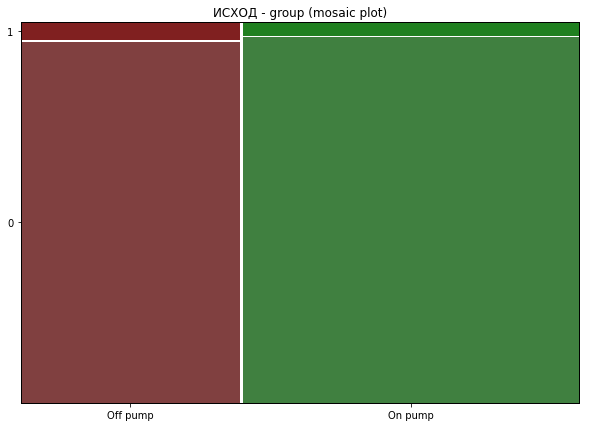

In [19]:
fig, ax = plt.subplots(1, 1,  figsize=(10, 7))

_ = mosaic(df_mp, ['group','ИСХОД'], ax=ax, labelizer=lambda _: "", title='ИСХОД - group (mosaic plot)')

Run test and print test results

In [20]:
res = stat()
res.chisq(df_ct)
print (res.summary)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            1       1.30905   0.252567
Log-likelihood     1       1.29025   0.256002



In [21]:
# Print expected values
print (res.expected_df)


Expected frequency counts

         0        1
--  ------  -------
 0   743.4  31.6004
 1  1138.6  48.3996



#### Groups of interest: 'Соч', 'Изол'

`df_test` DataFrame which contains relevant columns

In [22]:
df_test = df[['Соч', 'ИСХОД']].copy()
df_test['Изол'] = 1 - df_test[['Соч']]
df_test.head()

,Соч,ИСХОД,Изол
0,0,0,1
1,0,0,1
2,1,0,0
3,1,0,0
4,0,0,1


Contingency table

In [23]:
df_ct = df_test.groupby('ИСХОД').sum().transpose().astype('int')
df_ct

ИСХОД,0,1
Соч,350,14
Изол,1532,66


Mosaic plot

In [24]:
df_mp = (pd.melt(df_test, id_vars=['ИСХОД'], value_vars=['Соч', 'Изол'], var_name='group')
            .query('value== 1')
            .sort_values(['ИСХОД', 'group'])
            .drop('value',1))

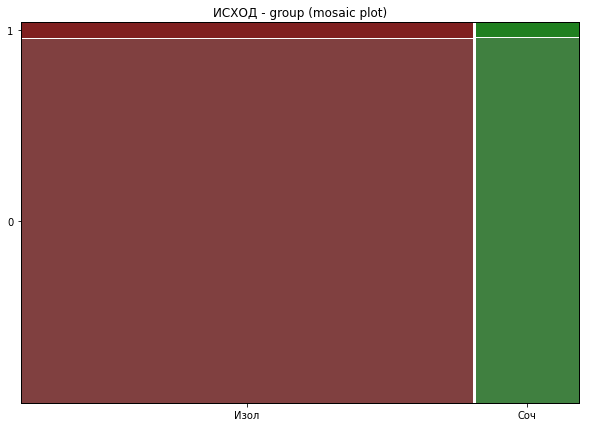

In [25]:
fig, ax = plt.subplots(1, 1,  figsize=(10, 7))

_ = mosaic(df_mp, ['group','ИСХОД'], ax=ax, labelizer=lambda _: "", title='ИСХОД - group (mosaic plot)')

Run test and print test results

In [26]:
res = stat()
res.chisq(df_ct)
print (res.summary)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            1     0.0100869   0.92
Log-likelihood     1     0.0101449   0.919771



In [27]:
# Print expected values
print (res.expected_df)


Expected frequency counts

           0       1
--  --------  ------
 0   349.158  14.842
 1  1532.84   65.158

